In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import pickle

import os 
import sys


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.feature_selection import SelectPercentile, chi2

#import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# import SGDRegressor
from sklearn.linear_model import SGDRegressor

In [2]:
data = 'Data/final_modeling.csv'

In [3]:
df = pd.read_csv(data)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,15000,2013.0,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black
1,27990,2012.0,gmc,others,good,8 cylinders,gas,68696.0,clean,other,4wd,truck,black
2,34590,2016.0,chevrolet,others,good,6 cylinders,gas,29499.0,clean,other,4wd,truck,silver
3,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey
4,29990,2016.0,chevrolet,others,good,6 cylinders,gas,17302.0,clean,other,4wd,truck,red


In [4]:
# count values where cylinders = other
df['year'].value_counts()

2013.0    8003
2014.0    7206
2012.0    7191
2015.0    6668
2017.0    6561
          ... 
1960.0      29
1959.0      28
1954.0      27
1958.0      21
1961.0      20
Name: year, Length: 69, dtype: int64

In [5]:
# drop cylinders = other
df = df[df['cylinders'] != 'other']

In [6]:
df = df[df['condition'] != 'salvage']

In [7]:
df = df[df['fuel'] != 'other']

In [8]:
df = df[df['manufacturer'] != 'others']

In [9]:
df = df[df['model'] != 'others']

In [10]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
3,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey
10,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,mini-van,silver
39,13950,2011.0,toyota,tacoma,good,4 cylinders,gas,151060.0,clean,automatic,rwd,truck,silver
59,2500,2008.0,honda,accord,good,6 cylinders,gas,204561.0,clean,automatic,fwd,sedan,silver
61,8100,2011.0,ford,escape,excellent,6 cylinders,hybrid,140000.0,clean,automatic,fwd,SUV,white


In [11]:
# paint color, condition, Title Status

In [12]:
def age(df):
    df['age'] = 2021 - df['year']
    df.drop('year', axis=1, inplace=True)
    return df

In [13]:
df = age(df)


In [14]:
df = df[df['age'] <= 30]

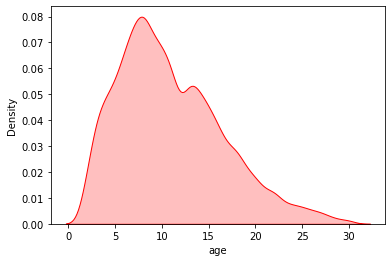

In [15]:
# kde plot of odometer
sns.kdeplot(df['age'], shade=True, color='r')
plt.show()

In [16]:
df

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
3,35000,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,2.0
10,14000,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,mini-van,silver,9.0
39,13950,toyota,tacoma,good,4 cylinders,gas,151060.0,clean,automatic,rwd,truck,silver,10.0
59,2500,honda,accord,good,6 cylinders,gas,204561.0,clean,automatic,fwd,sedan,silver,13.0
61,8100,ford,escape,excellent,6 cylinders,hybrid,140000.0,clean,automatic,fwd,SUV,white,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106633,32995,ram,3500,good,8 cylinders,gas,137499.0,clean,automatic,4wd,truck,brown,7.0
106636,34995,gmc,sierra,good,8 cylinders,gas,58095.0,clean,automatic,4wd,truck,black,7.0
106638,23995,toyota,tundra,good,8 cylinders,gas,114215.0,clean,automatic,4wd,truck,black,8.0
106639,15999,ram,3500,good,6 cylinders,gas,199090.0,clean,automatic,4wd,truck,white,21.0


In [17]:
df.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
3,35000,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,2.0
10,14000,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,mini-van,silver,9.0
39,13950,toyota,tacoma,good,4 cylinders,gas,151060.0,clean,automatic,rwd,truck,silver,10.0
59,2500,honda,accord,good,6 cylinders,gas,204561.0,clean,automatic,fwd,sedan,silver,13.0
61,8100,ford,escape,excellent,6 cylinders,hybrid,140000.0,clean,automatic,fwd,SUV,white,10.0


In [18]:
df.shape

(22745, 13)

In [20]:
# select random sample of 100000rows
df = df.sample(n=20000, random_state=42)

In [ ]:
# df = df.loc[:90000:,:]

In [21]:
numeric_features = ['odometer', 'age']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['manufacturer', 'model', 'fuel',\
                        'title_status', 'transmission', 'drive', 'type', 'paint_color']
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()), 
    ('selector', SelectPercentile(chi2, percentile=50))])

ordinal_features = ['condition', 'cylinders']
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('selector', SelectPercentile(chi2, percentile=50))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # X_train = preprocessor.fit_transform(X_train)
# # X_test = preprocessor.transform(X_test)
# y_train = np.log(y_train)
# y_test = np.log(y_test)

# model 
Regressor = RandomForestRegressor(max_depth=50, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', Regressor)])

# pipeline.fit(X_train, y_train)
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x17c992550>))]),
                                                  ['manufacturer', 'model',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x17c992550>))]),
                                                  ['condition',
                                                   'cylinders'])])),
                ('model',
                 RandomForestRegressor(max_depth=50, max_features=4,
                                       min_samples_leaf=3, min_samples_split=8,
                                       n_estimators=1000))])

In [22]:
pipeline.fit(X_train, y_train, model__sample_weight=y_train)
y_pred = pipeline.predict(X_test)

print('R2 score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))

R2 score:  0.8703145641925198
MAE:  2174.884096130281


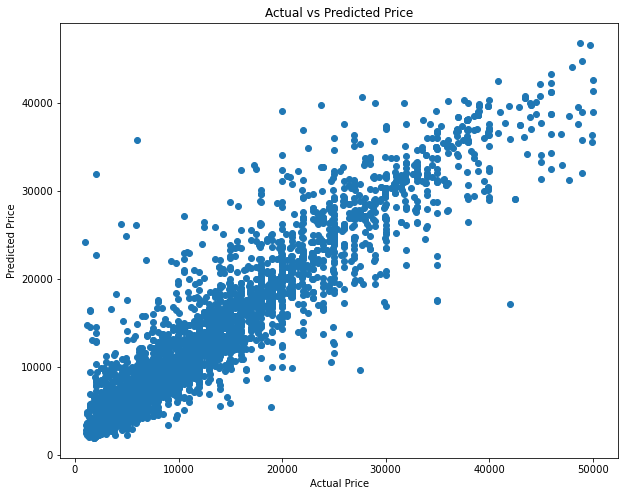

In [23]:
# scatter plot of actual vs predicted values. Predictions in red and actual values in black.

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [32]:
# get coefficients and slope intercept

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [24]:
# save predicted and actual values to dataframe
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_pred.head()

,Actual,Predicted
70320,20995,18306.755037
8446,6500,6038.602499
54425,4400,5924.227213
49127,12999,12178.521021
76348,4995,4399.378206


In [25]:
df_pred.to_csv('Data/df_pred.csv', index=False)

In [26]:
# save the model to disk
filename = 'cars_model_f.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

In [27]:
X_tester = X_test.iloc[[112]]

In [28]:
X_tester.head()

,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
81157,jeep,wrangler,excellent,4 cylinders,gas,127234.0,clean,manual,4wd,SUV,red,27.0


In [29]:
{'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'good',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 100000,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': '4wd',
 'type': 'truck',
 'paint_color': 'white',
 'age': 10}

{'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'good',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 100000,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': '4wd',
 'type': 'truck',
 'paint_color': 'white',
 'age': 10}

In [30]:
y_pred = pipeline.predict(X_tester)
print(y_pred)

[10755.17223777]


In [31]:
y_test.iloc[[112]]

81157    7950
Name: price, dtype: int64

In [ ]:
testmodel = pickle.load(open('cars_model.pkl', 'rb'))

In [ ]:
y_pred = testmodel.predict(X_tester)
print(y_pred)

[6267.20219951]


In [ ]:
import requests
import json

In [ ]:
# testing 
url = 'http://127.0.0.1:5000/predictcar'

data = {"manufacturer": "ford",
 "model": "f-150",
 "condition": "good",
 "cylinders": "6 cylinders",
 "fuel": "gas",
 "odometer": 100000,
 "title_status": "clean",
 "transmission": "automatic",
 "drive": "4wd",
 "type": "truck",
 "paint_color": "white",
 "year": 2010}

import requests
res = requests.post(url, json= data)
if res.ok:
    print(res)
    print(res.json())
else:
    print(res)

<Response [200]>
['Your predicted market value is :', 17714.832555157063]


In [ ]:
string = "5000"

In [ ]:
int(string)

5000